<a href="https://colab.research.google.com/github/rosselladedo/DOG_BREEDS_SEARCH_ENGINE/blob/main/LSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import time
import itertools
import os, shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import traceback
import sys
import sklearn
import re
import random as rand

from IPython.display import display
from ipywidgets import HBox, Image, HTML
from collections import OrderedDict
from sklearn import metrics
from sklearn.preprocessing import normalize

from random import random
from ipywidgets import Image
from numpy.linalg import norm
from IPython.display import display
from keras.models import Model
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from PIL import Image, ImageDraw
# tensorflow version 2.4.0
from tensorflow import keras

In [ ]:
DOGS_BREEDS = 120
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

MEAN_VECTOR = []

In [ ]:
#data directories
BASE_DIR = "/content/gdrive/Shareddrives/MIRCV"
IMAGES_DIR = "/content/gdrive/MyDrive/MIRCV"

TEST_PATH = os.path.join(BASE_DIR, "TestSet")
ALL_IMAGES_DIR = "/content/gdrive/Shareddrives/MIRCV/All_Images"
NOISE_DIR = "/content/gdrive/Shareddrives/Dataset/mirflickr25k/mirflickr"

# **UTILITY FUNCTIONS**

In [ ]:
#solo una volta
#(g(h=n.bit) 
def hashfunctions_generator(x_dim,g_dim,h_dim, binary = False, w=4 ):

  if binary:
    g=[]
    path = "/content/gdrive/Shareddrives/Dataset/HashFamilies/BinaryHashFamilies/"

    nome_file = "binaryhashfunctionsG" + str(g_dim) + "H" + str(h_dim)

    for g_iterator in tqdm(range(g_dim)):
      h = np.array(rand.sample(range(0, x_dim), h_dim))
      h.sort()
      g.append(h)
    
    np.save(path+nome_file,g)
  else:
    g=[]

    path = "/content/gdrive/Shareddrives/Dataset/HashFamilies/"
    nome_file = "hashfunctionsG" + str(g_dim) + "H" + str(h_dim)

    for g_iterator in tqdm(range(g_dim)):
      h=[]
      for h_iterator in range(h_dim):            #(p*x(i))+b/w
        v=[np.random.normal(0, 1, x_dim),np.random.uniform(0,w)]  #[x,b]   
        h.append(v)
      g.append(h)
    
    np.save(path+nome_file,g)

In [ ]:
#solo una volta
def execute_hashfunctions_generator():
  for g_dim in tqdm(range(1,21)):
    for h_dim in range(1,11):
      hashfunctions_generator(1024, g_dim, h_dim)

In [ ]:
#hashfunctions_generator(1024, 10, 2, False)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
def generate_mean_vector(features_vector):
  mean_vector = []
  for feat in tqdm(features_vector):
    f = feat[1]
    mean_vector.append(f)
  
  mean_vector = np.mean(mean_vector, axis = 0)
  return mean_vector

In [ ]:
def generate_binary_vector(mean_vector, features_vector):
  features_vector = features_vector[0]
  mean_vector = mean_vector[0]
  binary_vector = [0 if features_vector[i] < mean_vector[i] else 1 for i in range(len(features_vector))]

  return np.asarray(binary_vector)

In [ ]:
def take_features(path):
  features_arr = np.load(path, allow_pickle=True)
  features = features_arr['arr_0']
  return features

In [ ]:
#funzione per ordinare i risultati della query dal più "vicino" al più lontano

def make_ranking(q_features, features):

  result_euclidean = []
  
  q_name = q_features[0][0]
  q_features = q_features[0][1]
  
  q_features = normalize(q_features, axis=1)

  for item in tqdm(features):
    feat = item[1]
    name = item[0]

    feat = normalize(feat, axis=1)

    dist = np.linalg.norm(feat - q_features, axis=1)

    res = (np.double(dist), name)

    result_euclidean.append(res)

  ranking = sorted(result_euclidean)
  
  return ranking

In [ ]:
def display_image(image_path, title='', txt=''):
  """ Displays an image with optional title and text next to it using iPython
  widgets (works in Jupyter/Colab environments).
      
  Args:
    image_path (string): path to the image to show.
    title (string): header text to show next to the image.
    txt (string): text to show under the title header.
  """
  image_widget = Image.from_file(image_path, width=200, height=100)
  txt = txt.replace('\n', '<br>')
  text_widget = HTML('<p><b>{}</b></p><p>{}</p>'.format(title, txt))
  widget = HBox([image_widget, text_widget])
  display(widget)

In [ ]:
def unpad_image(image_pil):
  """ Removes white borders of the given PIL Image. """
  image_np = np.array(image_pil)
  rr, cc = np.nonzero((image_np != 255).any(axis=2))
  y0, y1 = rr.min(), rr.max()
  x0, x1 = cc.min(), cc.max()
  return image_pil.crop((x0, y0, x1, y1))


def make_image_grid(image_paths, relevance=None, rows=3, cols=8, thumbnail_size=(100, 100)):
  """ Makes a grid of images.
  Args:
    - image_paths (list): a list of image paths
    - relevance (list): if not None, indicates whether to add a green or red
                        indicator on each image.
    - rows, cols (int): the number of rows/cols of the image grid.
    - thumbnail_size (tuple): size of a cell as a (width, height) tuple.
  Returns:
    - grid (PIL.Image): the grid as a PIL Image.
  """
  cell_width, cell_height = thumbnail_size
  grid = Image.new('RGB', (cell_width * cols, cell_height * rows), color='white')
  draw = ImageDraw.Draw(grid)
  relevance = (None,) * len(image_paths) if relevance is None else relevance

  cells = itertools.product(range(rows), range(cols))  # every (row, col) combination
  for (row, col), image_path, rel in zip(cells, image_paths, relevance):
    if not os.path.exists(image_path):
      image_name = image_path.split('/')[6]
      image_path = os.path.join(NOISE_DIR, image_name)
    image_pil = Image.open(image_path).convert('RGB')
    image_pil = unpad_image(image_pil)
    image_pil.thumbnail(thumbnail_size)

    cell_x = cell_width * col + (cell_width - image_pil.width) // 2
    cell_y = cell_height * row + (cell_height - image_pil.height) // 2
    grid.paste(image_pil, (cell_x, cell_y))

    if rel is not None:
      color = 'green' if rel else 'red'
      x0 = cell_width * col + 5
      y0 = cell_height * (row + 1) - 3
      x1 = cell_width * (col + 1) - 5
      y1 = cell_height * (row + 1)
      draw.rectangle([x0, y0, x1, y1], fill=color)

  return grid

def display_results(query_image, ranks, mAP_vector, limit=10):
  """ Draws results of image searches.
  Args:
    - ranks (ndarray): a (Q,N)-shaped matrix of indices of retrieved elements
                       for each query, already ranked. E.g., ranks[0, 4] is the
                       index of fifth retrieved element with respect to query #0.
    - groundtruth (ndarray): a (Q,N)-shaped boolean matrix indicating relevance
                             of database elements to queries, i.e., if
                             groundtruth[3,2] is True, then the database element
                             #2 is relevant to the query #3.
    - queries_annot (pandas.DataFrame): information about queries.
    - db_annot (pandas.DataFrame): information about database elements.
    - limit (int): the number of top results to show.
  """
  
  image_paths = []
  image_relevance = []

  image_paths.append(os.path.join(TEST_PATH, query_image))
  image_relevance.append( None )
  
  counter = 0

  for rank in ranks:

    image_paths.append(os.path.join(ALL_IMAGES_DIR, rank[1]))
    image_relevance.append(mAP_vector[counter])

    counter = counter + 1

  grid = make_image_grid(image_paths, image_relevance, rows=1, cols=limit+1)
  display(grid)

In [ ]:
def mAP_calculation(query_img, num_dogs_performance = 5):
  query_label = query_img.split("_")[0]
  results = res
  
  denom = num_dogs_performance

  mAP = 0

  for r in results:

    if num_dogs_performance == 0:
      break
    if r == None:
      break

    result_label = r[1].split("_")[0]
    #print(result_label)

    if query_label == result_label:
      mAP = mAP + 1

    num_dogs_performance = num_dogs_performance -1

  mAP = mAP/denom

In [ ]:
def return_rank_mAP(query, rank):
  mAP_vector = []
  query_label = query.split("_")[0]

  for dog in rank:
    result_label = dog[1].split("_")[0]
    if query_label == result_label:
      mAP_vector.append(1)
    else:
      mAP_vector.append(0)
      
  return mAP_vector

# **NO FINETUNED MODEL**

In [ ]:
#funzione che inserisce una data immagine nei bucket corretti

def insert(p, nomefoto, g, binary, MEAN_VECTOR, w = 4):

  if binary == True:
    g_dim = 1
    for hash_family in g:
      inserted_object = ''
      binary_vector = generate_binary_vector(MEAN_VECTOR, p)
      for hash_function in hash_family:
        bucket = binary_vector[hash_function]
        inserted_object=inserted_object+ "[" + str(bucket) + "]"  #creao la stringa nome con tutti i buckets

      pathbucket = "/content/gdrive/Shareddrives/Dataset/Buckets/BinaryBuckets/bucketsG" + str(len(g)) + "H" + str(len(hash_family))
      if not os.path.exists(pathbucket):
        os.mkdir(pathbucket)  #si crea la cartella se non esiste
      pathbucket = "/content/gdrive/Shareddrives/Dataset/Buckets/BinaryBuckets/bucketsG" + str(len(g)) + "H" + str(len(hash_family)) + "/" + str(g_dim)
      if not os.path.exists(pathbucket):
        os.mkdir(pathbucket)  #si crea la cartella se non esiste
      filesaved=open(pathbucket+'/'+inserted_object,'a+')   #apri il documento con il percorso specificato 
      filesaved.write(nomefoto+'\n')                        #salvo il nome dell'immagine nel file corretto
      filesaved.close()
      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
      
  else:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    for hash_family in g:
      inserted_object = ''
      for hash_function in hash_family:
        prodotto = np.dot(p,hash_function[0])  #p*x
        somma = prodotto + hash_function[1]    #p*x + b
        divisione = somma / w             #(p*x + b)/w
        inserted_object=inserted_object+str(np.transpose(np.trunc(divisione)).astype(int))  #creao la stringa nome con tutti i buckets

      pathbucket = "/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG" + str(len(g)) + "H" + str(len(hash_family))
      if not os.path.exists(pathbucket):
        os.mkdir(pathbucket)  #si crea la cartella se non esiste
      pathbucket = "/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG" + str(len(g)) + "H" + str(len(hash_family)) + "/" + str(g_dim)
      if not os.path.exists(pathbucket):
        os.mkdir(pathbucket)  #si crea la cartella se non esiste
      filesaved=open(pathbucket+'/'+inserted_object,'a+')   #apri il documento con il percorso specificato 
      filesaved.write(nomefoto+'\n')                        #salvo il nome dell'immagine nel file corretto
      filesaved.close()
      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies

In [ ]:
#funzione che esegue la insert (sopra), vanno specificate il numero di hash family e il numero di hash functions per ogni hash family

def insert_execution(g_dim, h_dim, binary = False):

  features = take_features("/content/gdrive/Shareddrives/Dataset/Features/features_NM_concatenate_predict.npz")
  MEAN_VECTOR = generate_mean_vector(features)
  if binary == True:
    bucketsaved=np.load("/content/gdrive/Shareddrives/Dataset/HashFamilies/BinaryHashFamilies/binaryhashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy", allow_pickle = True)
  else:
    bucketsaved=np.load("/content/gdrive/Shareddrives/Dataset/HashFamilies/hashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy",allow_pickle=True)   #bucket salvati 

  for p in tqdm(features):
    nomefoto=p[0]
    featuresfoto=p[1]
    insert(featuresfoto, nomefoto, bucketsaved, binary, MEAN_VECTOR)

"""
########################################################
##### TO RUN ALL BUCKETS ###############################
########################################################
def execute(g_dim, h_dim):
  for g in range(1:21):
    for h in range(5:11):
      insert_execution(g, h)
"""

'\n########################################################\n##### TO RUN ALL BUCKETS ###############################\n########################################################\ndef execute(g_dim, h_dim):\n  for g in range(1:21):\n    for h in range(5:11):\n      insert_execution(g, h)\n'

In [ ]:
insert_execution(10, 2, False)

  0%|          | 0/44580 [00:00<?, ?it/s]

  0%|          | 0/44580 [00:00<?, ?it/s]

In [ ]:
#model
model = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet', input_tensor=None, input_shape=(224,224,3), 
    pooling='avg', include_top=False
)

model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
#query extraction feature

def extract_features_query_index(img):
  query_features = []
  image_path = os.path.join(TEST_PATH, img)
  image_pil = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE, interpolation='bilinear')
  image_pil = np.array(image_pil)
  image_pil = image_pil.astype(np.float32)
  image_np = tf.keras.applications.densenet.preprocess_input(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_feature_vector = model.predict(image_np)
  feat_name = (img, image_feature_vector)
  query_features.append(feat_name)

  np.savez("/content/gdrive/Shareddrives/Dataset/Features/features_query_index_NM.npz", query_features)

In [ ]:
#funzione che inserisce la query nei corretti buckets per ogni hash family

def insert_query(binary, MEAN_VECTOR, p, g, w = 4):
  result = []

  if binary:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    for hash_family in g:
      inserted_object = ''
      binary_vector = generate_binary_vector(MEAN_VECTOR, p)
      for hash_function in hash_family:
        bucket = binary_vector[hash_function]
        inserted_object=inserted_object+ "[" + str(bucket) + "]"  #creao la stringa nome con tutti i buckets
        
      inserted_object = str(g_dim) + "/" + inserted_object
      result.append(inserted_object)

      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
  else:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    p = p[0][1]
    for hash_family in g:
      inserted_object = ''
      for hash_function in hash_family:
        prodotto = np.dot(p,hash_function[0])  #p*x
        somma = prodotto + hash_function[1]    #p*x + b
        divisione = somma / w             #(p*x + b)/w
        inserted_object=inserted_object+str(np.transpose(np.trunc(divisione)).astype(int))  #creao la stringa nome con tutti i buckets
      inserted_object = str(g_dim) + "/" + inserted_object
      result.append(inserted_object)

      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
  return result

In [ ]:
############################################################
#q_features = features query; g = hash families (necessaria variabile globale)
def query_execution(binary, g_dim, h_dim, q_features, features, MEAN_VECTOR):
  path_hash_functions = ""
  path_bucket = ""

  if binary == True:
    path_hash_functions = "/content/gdrive/Shareddrives/Dataset/HashFamilies/BinaryHashFamilies/binaryhashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy"
    path_bucket = "/content/gdrive/Shareddrives/Dataset/Buckets/BinaryBuckets/bucketsG" + str(g_dim) + "H" + str(h_dim)
  else:
    path_hash_functions = "/content/gdrive/Shareddrives/Dataset/HashFamilies/hashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy"
    path_bucket = "/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG" + str(g_dim) + "H" + str(h_dim)
  
  
  result = []
  
  bucketsaved=np.load(path_hash_functions, allow_pickle=True)
  
  buckets_query = insert_query(binary, MEAN_VECTOR, q_features, bucketsaved) #calcolo i buckets della nostra query
  for b in buckets_query:
    if os.path.exists(os.path.join(path_bucket, b)):
      
      file_hash=open(os.path.join(path_bucket, b),'r')
      r = file_hash.readlines()                      
      file_hash.close()
      result.append(r)

  return result

In [ ]:
#funzione per eseguire la query e stampare i risultati

def search_and_print(g_dim,h_dim,image_name, binary = False):

  print("image name query: " + str(image_name))
  extract_features_query_index(image_name)
  q_features = take_features("/content/gdrive/Shareddrives/Dataset/Features/features_query_index_NM.npz")
  features=take_features("/content/gdrive/Shareddrives/Dataset/Features/features_NM_concatenate_predict.npz")

  MEAN_VECTOR = generate_mean_vector(features)

  starting_time = time.time()
  query_result = query_execution(binary, g_dim, h_dim, q_features, features, MEAN_VECTOR)
  ending_time = time.time()

  query_execution_time = ending_time - starting_time
  print("Time for the query execution: " + str(query_execution_time))

  query_result_splitted = []
  features_results=[]

  for r in query_result:
    for name in r:
      query_result_splitted.append(name.split('\n')[0])

  image_no_duplicates= list(OrderedDict.fromkeys(query_result_splitted))
  
  for f in features:
    for s in image_no_duplicates:
      if str(f[0])==s:
        features_results.append(f)

  images_to_print = make_ranking(q_features, features_results)

  mAP_vector = return_rank_mAP(image_name, images_to_print)
  display_results(image_name, images_to_print[:10], mAP_vector)

  return images_to_print

In [ ]:
query_img = "n02086646_3053.jpg"

image name query: n02086646_3053.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 0.019675016403198242


  0%|          | 0/1472 [00:00<?, ?it/s]

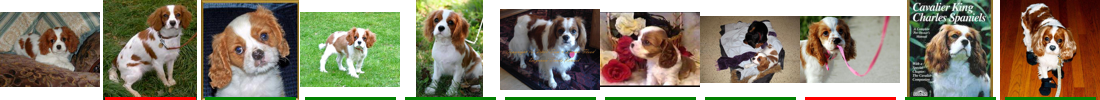

In [ ]:
res = search_and_print(10, 2, query_img, False)
#res = search_and_print(10, 10, query_img, True) #binary execution

# **LSH FINETUNED MODEL**

In [ ]:
#funzione che inserisce una data immagine nei bucket corretti

def insert_finetuned(p, nomefoto, g, binary, MEAN_VECTOR, w = 4):

  if binary == True:
    g_dim = 1
    for hash_family in g:
      inserted_object = ''
      binary_vector = generate_binary_vector(MEAN_VECTOR, p)
      for hash_function in hash_family:
        bucket = binary_vector[hash_function]
        inserted_object=inserted_object+ "[" + str(bucket) + "]"  #creao la stringa nome con tutti i buckets

      pathbucket = "/content/gdrive/Shareddrives/Dataset/Buckets/BinaryBuckets/FinetunedBuckets/bucketsG" + str(len(g)) + "H" + str(len(hash_family))
      if not os.path.exists(pathbucket):
        os.mkdir(pathbucket)  #si crea la cartella se non esiste
      pathbucket = "/content/gdrive/Shareddrives/Dataset/Buckets/BinaryBuckets/FinetunedBuckets/bucketsG" + str(len(g)) + "H" + str(len(hash_family)) + "/" + str(g_dim)
      if not os.path.exists(pathbucket):
        os.mkdir(pathbucket)  #si crea la cartella se non esiste
      filesaved=open(pathbucket+'/'+inserted_object,'a+')   #apri il documento con il percorso specificato 
      filesaved.write(nomefoto+'\n')                        #salvo il nome dell'immagine nel file corretto
      filesaved.close()
      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
      
  else:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    for hash_family in g:
      inserted_object = ''
      for hash_function in hash_family:
        prodotto = np.dot(p,hash_function[0])  #p*x
        somma = prodotto + hash_function[1]    #p*x + b
        divisione = somma / w             #(p*x + b)/w
        inserted_object=inserted_object+str(np.transpose(np.trunc(divisione)).astype(int))  #creao la stringa nome con tutti i buckets

      pathbucket = "/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG" + str(len(g)) + "H" + str(len(hash_family))
      if not os.path.exists(pathbucket):
        os.mkdir(pathbucket)  #si crea la cartella se non esiste
      pathbucket = "/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG" + str(len(g)) + "H" + str(len(hash_family)) + "/" + str(g_dim)
      if not os.path.exists(pathbucket):
        os.mkdir(pathbucket)  #si crea la cartella se non esiste
      filesaved=open(pathbucket+'/'+inserted_object,'a+')   #apri il documento con il percorso specificato 
      filesaved.write(nomefoto+'\n')                        #salvo il nome dell'immagine nel file corretto
      filesaved.close()
      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies

In [ ]:
#funzione che esegue la insert (sopra), vanno specificate il numero di hash family e il numero di hash functions per ogni hash family

def insert_finetuned_execution(g_dim, h_dim, binary = False):

  features = take_features("/content/gdrive/Shareddrives/Dataset/Features/features_finetuned_concatenate_predict.npz")
  MEAN_VECTOR = generate_mean_vector(features)
  if binary == True:
    bucketsaved=np.load("/content/gdrive/Shareddrives/Dataset/HashFamilies/BinaryHashFamilies/binaryhashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy", allow_pickle = True)
  else:
    bucketsaved=np.load("/content/gdrive/Shareddrives/Dataset/HashFamilies/hashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy",allow_pickle=True)   #bucket salvati 

  for p in tqdm(features):
    nomefoto=p[0]
    featuresfoto=p[1]
    insert_finetuned(featuresfoto, nomefoto, bucketsaved, binary, MEAN_VECTOR)

In [ ]:
insert_finetuned_execution(10, 10, True)

  0%|          | 0/44580 [00:00<?, ?it/s]

  0%|          | 0/44580 [00:00<?, ?it/s]

In [ ]:
model_finetuned = keras.models.load_model('/content/gdrive/Shareddrives/MIRCV/Models/Fine_Tuning_Model6_Flatten_512120_LR0001')

model = keras.models.Model(inputs=model_finetuned.input, outputs=model_finetuned.get_layer('flatten').output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
#query extraction feature

def extract_features_query_finetuned(img):
  query_features = []
  image_path = os.path.join(TEST_PATH, img)
  image_pil = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE, interpolation='bilinear')
  image_pil = np.array(image_pil)
  image_pil = image_pil.astype(np.float32)
  image_np = tf.keras.applications.densenet.preprocess_input(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_feature_vector = model.predict(image_np)
  feat_name = (img, image_feature_vector)
  query_features.append(feat_name)

  np.savez("/content/gdrive/Shareddrives/Dataset/Features/features_finetuned_query_index.npz", query_features)

In [ ]:
#funzione che inserisce la query nei corretti buckets per ogni hash family

def insert_finetuned_query(binary, MEAN_VECTOR, p, g, w = 4):
  result = []

  if binary:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    for hash_family in g:
      inserted_object = ''
      binary_vector = generate_binary_vector(MEAN_VECTOR, p)
      for hash_function in hash_family:
        bucket = binary_vector[hash_function]
        inserted_object=inserted_object+ "[" + str(bucket) + "]"  #creao la stringa nome con tutti i buckets
        
      inserted_object = str(g_dim) + "/" + inserted_object
      result.append(inserted_object)

      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
  else:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    p = p[0][1]
    for hash_family in g:
      inserted_object = ''
      for hash_function in hash_family:
        prodotto = np.dot(p,hash_function[0])  #p*x
        somma = prodotto + hash_function[1]    #p*x + b
        divisione = somma / w             #(p*x + b)/w
        inserted_object=inserted_object+str(np.transpose(np.trunc(divisione)).astype(int))  #creao la stringa nome con tutti i buckets
      inserted_object = str(g_dim) + "/" + inserted_object
      result.append(inserted_object)

      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
  return result

In [ ]:
############################################################
#q_features = features query; g = hash families (necessaria variabile globale)
def query_finetuned_execution(binary, g_dim, h_dim, q_features, features, MEAN_VECTOR):

  if binary == True:
    path_hash_functions = "/content/gdrive/Shareddrives/Dataset/HashFamilies/BinaryHashFamilies/binaryhashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy"
    path_bucket = "/content/gdrive/Shareddrives/Dataset/Buckets/BinaryBuckets/FinetunedBuckets/bucketsG" + str(g_dim) + "H" + str(h_dim)
  else:
    path_hash_functions = "/content/gdrive/Shareddrives/Dataset/HashFamilies/hashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy"
    path_bucket = "/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG" + str(g_dim) + "H" + str(h_dim)
    
  result = []
  
  bucketsaved=np.load(path_hash_functions, allow_pickle=True)
  
  buckets_query = insert_finetuned_query(binary, MEAN_VECTOR, q_features, bucketsaved) #calcolo i buckets della nostra query

  for b in buckets_query:
    if os.path.exists(os.path.join(path_bucket, b)):
      file_hash=open(os.path.join(path_bucket, b),'r')
      r = file_hash.readlines()                      
      file_hash.close()
      result.append(r)

  return result

In [ ]:
#funzione per eseguire la query e stampare i risultati

def search_and_print_finetuned(g_dim, h_dim, image_name, binary):
  print("image name query: " + str(image_name))
  extract_features_query_finetuned(image_name)
  q_features = take_features("/content/gdrive/Shareddrives/Dataset/Features/features_finetuned_query_index.npz")
  features = take_features("/content/gdrive/Shareddrives/Dataset/Features/features_finetuned_concatenate_predict.npz")

  MEAN_VECTOR = generate_mean_vector(features)

  starting_time = time.time()
  query_result = query_finetuned_execution(binary, g_dim, h_dim, q_features, features, MEAN_VECTOR)
  ending_time = time.time()

  query_execution_time = ending_time - starting_time
  print("Time for the query execution: " + str(query_execution_time))

  query_result_splitted = []
  features_results=[]

  for r in query_result:
    for name in r:
      query_result_splitted.append(name.split('\n')[0])

  image_no_duplicates= list(OrderedDict.fromkeys(query_result_splitted))
  
  for f in features:
    for s in image_no_duplicates:
      if str(f[0])==s:
        features_results.append(f)

  images_to_print = make_ranking(q_features, features_results)

  mAP_vector = return_rank_mAP(image_name, images_to_print)
  display_results(image_name, images_to_print[:20], mAP_vector)

  """
  count = 1
  display_image(os.path.join(TEST_PATH, image_name), 'Query')

  for i in images_to_print:
    name = i[1]
    display_image(os.path.join(ALL_IMAGES_DIR, name), name)
    if count == 10:
      break
    count = count + 1
  """
  return images_to_print

In [ ]:
query_img = 'n02086646_3053.jpg'

image name query: n02086646_3053.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 3.9734582901000977


  0%|          | 0/2213 [00:00<?, ?it/s]

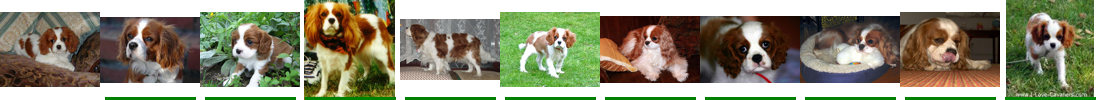

In [ ]:
res = search_and_print_finetuned(10, 2, query_img, False)
#res = search_and_print_finetuned(10, 10, query_img, True) #binary execution